# Bayesian inference of parameters in an elliptic partial differential equation

We consider the estimation of parameters in an elliptic partial differential equation:
\begin{equation}
\begin{cases} 
        - \nabla\cdot m \nabla u = f & \text{in }\Omega\,;\\ 
        u = 0 & \text{on }\partial\Omega\,,
\end{cases}
\end{equation}
where $\Omega = [0, 1]^2$, $f = 100\sin(4\pi s_1)\sin(4\pi s_2)$, and $m:\Omega\to\mathbb{R}$ is of the form of a Gaussian function:
\begin{equation}
m = p\exp\left(-\frac{(s_1-c_1)^2}{2d^2} - \frac{(s_2-c_2)^2}{2d^2}\right)
\end{equation}
In this document, we use the DRAM algorithm and the FEniCS library to infer the uncertain parameters $\mathbf{x} = (p, c_1, c_2, d)$, given sparse observation of the state $u$.

Our quantity of interest (QoI) is defined as follows:
$$ \mathcal{Q}(m) = \int_\Omega m(\mathbf{s}) \,d\mathbf{s}$$

Frist, we import the libraries needed:

In [1]:
import numpy as np
import dolfin as dl
import sys, os
sys.path.append( os.environ.get('HIPPYLIB_PATH'))
import hippylib as hl
import math
sys.path.insert(0, '../../')
from dram import *
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size = 15)
np.random.seed(0)
dl.set_log_active(False)

Now we create the function and real vector spaces for the state $u$ and the parameters $m$. We consider a triangular finite element mesh of size $n_h\times n_h$ cells with $n_h = 80$.

In [2]:
# Create mesh and define function spaces
n_h = 80
param_dim = 4
order = 1
mesh = dl.UnitSquareMesh(n_h, n_h) #Create a square domain mesh of nx times nx cells
Vu = dl.FunctionSpace(mesh, 'Lagrange', order) #Create Lagrange triangular elements of assigned order
Vm = dl.VectorFunctionSpace(mesh, "R", degree=0, dim=param_dim) #Create real value vector space

# Define the indeces for the spaces
STATE = 0
PARAMETER = 1

# Define the spaces
Vh = [Vu, Vm]
ndofs = [Vh[STATE].dim(), Vh[PARAMETER].dim()]
print("DoFs of the state variable:", ndofs[STATE])
print("DoFs of the parameter variable:", ndofs[PARAMETER])

DoFs of the state variable: 6561
DoFs of the parameter variable: 4


We define the boundary condition object to apply Dirichlet boundary in the forward problem

In [3]:
# Define the boundary condition
def boundary(x,on_boundary):
    return on_boundary

bc = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

## Part I: Creating the forward problem

In the first part of the document, we demonstrate how to create the forward problem. In particular, it must has the following components:
1. A `generate_state` function that returns an initialized state dolfin vector.
2. A `genetrate_parameter` function that retuns an initialized parameter dolfin vector.
3. A `solveFwd` function that solves the forward problem for a given parameter dolfin vector.

The first two are quite strightforward. The `solveFwd` function needs customization.

The class below is the forward problem for the elliptic partial differential equation defined above. In particular, we solve the weak problem:
$$ \text{Find } u\in H^1_0 \text{ such that: }\quad \int_\Omega m(\mathbf{x})\nabla u\cdot \nabla v\,d\mathbf{s} + \int_\Omega fv\,d\mathbf{s} = 0\quad \forall v\in H^1_0(\Omega)\,.$$
We denote the solution operator to the forward problem as
$$ u = \mathcal{F}(\mathbf{x})\,.$$

In [4]:
class forward_problem():
    #The forward problem is initialized with the spaces and the boundary condition.
    def __init__(self, Vh, bc):
        self._Vh = Vh
        self._bc = bc
        #Define the form of the parameter field
        self._param = self.generate_parameter() 
        
        #Assemble rhs of the variational form
        self._u_test = dl.TestFunction(self._Vh[STATE])
        f_form = dl.Expression("100*sin(4*pi*x[0])*sin(4*pi*x[1])", degree = 5)
        self.f = dl.interpolate(f_form, self._Vh[STATE])
        self._rhs = dl.assemble(self.f*self._u_test*dl.dx)
        
        self._u_trial = dl.TrialFunction(self._Vh[STATE]) #For assemble lhs
        self._solver = dl.PETScLUSolver() #For solving the Poisson problem
        
    def generate_state(self):
        #Initialize a state dolfin vector
        return dl.Function(self._Vh[STATE]).vector()
    
    def generate_parameter(self):
        #Initialize a parameter dolfin vector
        return dl.Function(self._Vh[PARAMETER]).vector() 
    
    def set_parameter_field(self, param):
        #Generate the parameters field
        m_form = dl.Expression("p*exp(-0.5*(pow(x[0] - c_1, 2))/(2*pow(d,2))- 0.5*(pow(x[1] - c_2, 2))/(2*pow(d,2)))",\
                              p = param[0], c_1 = param[1], c_2 = param[2], d = param[3], degree = 5)
        self.m = dl.interpolate(m_form, self._Vh[STATE])
    
    def solveFwd(self, out, x): 
        #x is a list of a state dolfin vector and a parameter dolfin vector.
        #x[PARAMETER] contains the parameter values for solving the forward problem.
        
        #reset the parameter field
        self.set_parameter_field(x[PARAMETER])
        
        #Assemble the lhs matrix
        A = dl.assemble(self.m*dl.inner(dl.grad(self._u_trial), dl.grad(self._u_test))*dl.dx)
        
        #Apply the boundary condition
        self._bc.apply(A, self._rhs)
        
        #Solve the poisson problem
        self._solver.solve(A, out, self._rhs)

Now we play around with the forward problem created above. We solve the forward problem at the parameter 
$$\mathbf{x}_t = (0.6, 0.7, 0.2, 0.4)\,,\quad u_t=\mathcal{F}(\mathbf{x}_t)$$

In [5]:
pde = forward_problem(Vh, bc)
param_true = np.array([0.6, 0.7, 0.2, 0.4])
var_truth = [pde.generate_state(), pde.generate_parameter()] #Create a varaible list
var_truth[PARAMETER].set_local(param_true) #Setting the parameter values
pde.solveFwd(var_truth[STATE], var_truth) #Solve the forward problem

The parameter field $m$ at $\mathbf{x}_t$, along with the right hand side forcing term and the solution state are plotted.

QoI at x_t is 0.4010


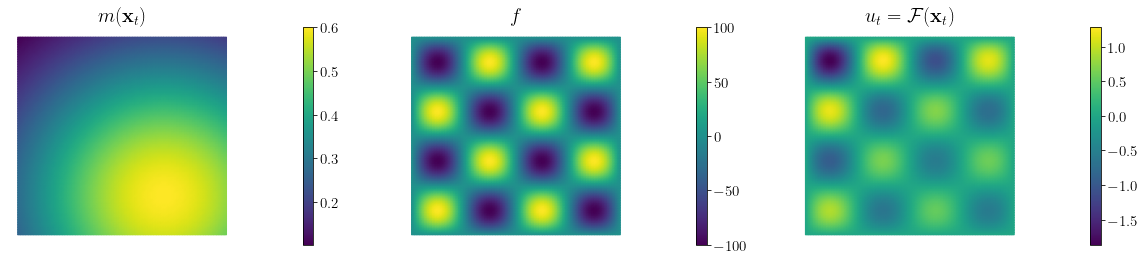

In [6]:
qoi_true = dl.assemble(pde.m*dl.dx) #Compute the QoI value at the assigned parameter value.
print("QoI at x_t is {0:2.4f}".format(qoi_true))

u_0 = dl.Function(Vh[STATE])
u_0.vector().zero()
u_0.vector().axpy(1., var_truth[STATE]) #Assign the state dolfin vector to a state function

plt.figure(figsize=(20,4))
hl.nb.plot(pde.m,subplot_loc=131, mytitle=r"$m(\mathbf{x}_t)$")
hl.nb.plot(pde.f,subplot_loc=132, mytitle=r"$f$")
hl.nb.plot(u_0,subplot_loc=133, mytitle=r"$u_t =\mathcal{F}(\mathbf{x}_t)$") #Plot the state function
plt.show()

## Part II: Creating the observation and likelihood models

In the second part of this document, we define the observation and likelihood models and demonstrate how to implement them. In particular, only one component is strictly required:
1. A `cost` function that returns the negative log-likelihood evaulation at a pair of state and parameter dolfin vectors.

For this problem, however, we implement a relatively complicated observation model. We first consider a "pixelization" of the state $u$ to a $n_h\times n_h$ locally averaged matrix.
$$ \mathbf{o}_{jk} = \int_{\Omega_{jk}} u\,d\mathbf{s}\,,\quad \Omega_{jk} = [(j-1)/n_h, j/n_h]\times[(k-1)/n_h, k/n_h]\,.$$
An additive i.i.d. white noise with standard deviation of $\sigma_n = 0.2$ is applied to the entries:
$$\mathbf{d}_{jk} = \mathbf{o}_{jk} + \mathbf{n}\,,\quad \mathbf{n}\sim\mathcal{N}(0, \sigma_n^2)\,.$$
Then we only observe a randomly selected $250$ entries in the index set $\mathcal{I}$ to compute the negative log likelihood:
$$\mathcal{L}(\mathbf{x};\mathbf{d}) = (2\sigma_n^2)^{-1}\sum_{(j,k)\in \mathcal{I}}\left|\mathbf{d}_{jk} - \int_{\Omega_{jk}} \mathcal{F}(\mathbf{x})\,d\mathbf{s}\right|^2$$

Here is the implementation of the observation and likelihood model

In [7]:
class likelihood():
    def __init__(self, Vh):
        #The likelihood model is initialized with the state and parameter spaces:
        self._Vh = Vh
        self._u = dl.Function(Vh[STATE])
        self._n_h = round(np.sqrt(Vh[STATE].dim())) -1 #The state space is used to define n_h
    
    def state2image(self, state):
        #Compute the pixelized state from a state dolfin vector
        self._u.vector().zero()
        self._u.vector().axpy(1., state)
        image = self._u.compute_vertex_values().reshape(self._n_h+1, self._n_h+1)
        image_averaged = np.zeros((self._n_h, self._n_h))
        # Pixelization by local averaging
        for i in range(self._n_h -1):
            for j in range(self._n_h -1):
                image_averaged[i, j] += image[i, j]
                image_averaged[i, j] += image[i, j + 1]
                image_averaged[i, j] += image[i + 1, j]
                image_averaged[i, j] += image[i + 1, j + 1]
        return np.flip(image_averaged, axis = 0) * 0.25
    
    def image2observable(self, img, index):
        #Extract the sparse observation from the pixelized state
        obs = np.zeros(index.shape[0])
        for i in range(index.shape[0]):
            obs[i] = img[self._n_h - index[i, 1]-1, index[i, 0]]
        return obs
        
    def set_data(self, data, index, sigma_n):
        #Assign the observation data
        self._data = data
        self._sigma_n = sigma_n
        self._index = index
        
    def cost(self, x):
        #Compute the negative log-likelihood.
        img = self.state2image(x[STATE])
        obs = self.image2observable(img, self._index)
        return 0.5*np.linalg.norm(obs-self._data)**2/self._sigma_n**2
        

Now we play around with the likelihhod model. We consider a synthetically generated data with the forward model solution $u_t$ computed in Part I. 

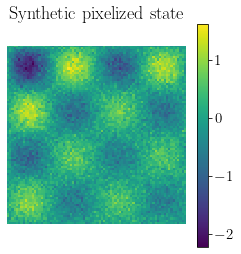

In [8]:
llh = likelihood(Vh)
sigma_n = 0.2
img_data = llh.state2image(var_truth[STATE]) + np.random.normal(scale = sigma_n, size = (n_h, n_h))
cmap = plt.matshow(img_data)
plt.colorbar(cmap)
plt.axis("off")
plt.title(r"Synthetic pixelized state")
plt.show()

We select randomly $100$ pairs of indices from $[0, n_h]$ to set up the incomplete observation, complying with the coustimized setup of the likelihood model.

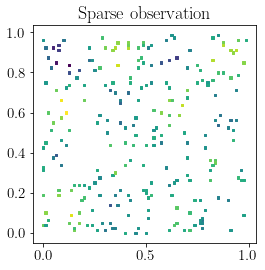

In [9]:
index = np.random.randint(0, n_h, size = (250, 2))
obs = llh.image2observable(img_data, index)
plt.figure(figsize = (4,4))
plt.scatter(index[:, 0]/n_h, index[:, 1]/n_h, c = obs, marker = ",", s=5)
plt.title("Sparse observation")
llh.set_data(obs, index, sigma_n)

## Part III: Creating the parameter prior

In the third part of this document, we define the parameter prior model and demonstrate how to implement it. In particular, three components are required:
1. An `init_vector` function that initializes an empty dolfin vector to be a parameter dolfin vector.
2. A `cost` function that returns the negative log-pdf evaulation at a given parameter dolfin vector.
3. A `sample` function that gives i.i.d. samples from the distribution.

Threre are several prior distribution available in the DRAM library or the hippylib library:
1. `UniformPrior`: the "boxed" uniform distribution.
    Input: the upper bound and low bound vector.
2. `KDEPrior`: the kernel density approximate distribution.
    Input: a set of parameter samples.
3. `GaussianRealPrior`:the Gaussian distribution.
    Input: The Covariance matrix and the mean vector.

Note that the `sample` functions for the prior options above are configured to be compatible with the default prior model in the hIPPYlib library. In particular, the `sample` function requires an input of a sample from the standard gaussian or the unit boxed uniform distribution. The format is not strictly required, as the `sample` function is only used for explicitly initialize the MCMC chain.

In this document, we use the unit boxed uniform prior provided along with the DRAM algorithm:
$$ \mathbf{X}\sim \mathcal{U}([0, 1]^4)$$

In [10]:
upper = np.array([1.0, 1.0, 1.0, 1.0])
prior = UniformPrior(Vh[PARAMETER], upper) 

Note that the lower bound is optional for the boxed unifrom prior. The default valuea are all zeros. One can use the option `lower_bound =` to assign the lower bound values.

Now we play around with the prior created above. We draw samples from the prior and visualize them

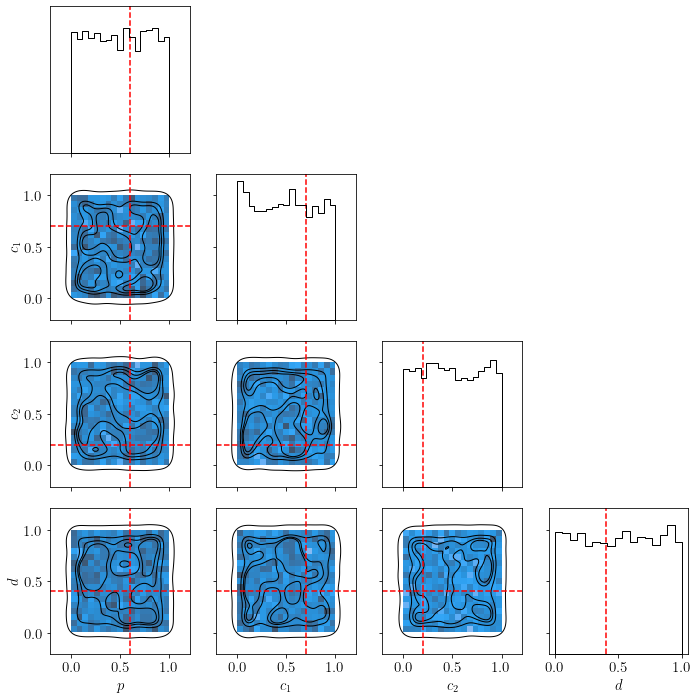

In [11]:
n_param_samples = 5000
noise = pde.generate_parameter()
param = pde.generate_parameter()
param_array = np.zeros((n_param_samples, param_dim))
for i in range(n_param_samples):
    param.zero()
    noise.set_local(np.random.uniform(low = 0.0, high = 1.0, size = param_dim))
    # To sample from the prior, one needs to provide a parameter dolfin vector sample with unit boxed unifrom distribution
    # This is not strictly required if one wishes to coustimize prior.
    prior.sample(noise, param)
    param_array[i, :] = param.get_local()
labels = [r"$p$", r"$c_1$", r"$c_2$", r"$d$"]
plot_joint_density(param_array, scatter = False, reference = param_true, labels = labels)

## Part III: Setting up a MCMC run

With the forward problem, the likelihood model, and the parameter prior defined, we proceed to set up a MCMC run using the DRAM algorithm. First, we combine the three objects defined above into a model object.

In [12]:
model = hl.Model(pde, prior, llh)

Then we initialize the DRAM kernel with an initial proposal std, provided as a numpy array. The DRAM kernel has the following parameters:
1. `non-adaptive_samples`: the number of samples before the adaptive metropolis is activated. The default value is $20$.
2. `maximum_proposals`: the maximum number of stages for delayed rejection. The default value is $3$.
3. `dr_proposal_scale`: the scaling of the proposal covariance at each stage. The default value is $0.1$.
4. `next_stage_probability`: the probability of initiating the next stage. The default value is $0.5$.

In [13]:
proposal_std = np.ones(param_dim)*0.25
kernel = DRAMKernel(model, proposal_std)
kernel.parameters["non-adaptive_samples"]  = 20
kernel.parameters["maximum_proposals"]  = 3
kernel.parameters["DR_proposal_scale"]  = 0.1
kernel.parameters["next_stage_probability"]  = 0.5

Next, we initialize a MCMC chain sampling object with the kernel. It has the following parameters:
1. `number_of_samples`: the total number of samples. The default value is $5000$.
2. `print_progress`: the number of screen print for checking progress. The default value is $20$.
3. `print_level`: the printing level, where positive means print and negative means not print. The deault value is $1$.

In [ ]:
chain = DRAM_MCMC(kernel)
chain.parameters["number_of_samples"]     = 10000
chain.parameters["print_progress"]        = 10
chain.parameters["print_level"]           = 1

We now define the QoI obeject, which contains a `evaluate` function that returns the QoI prediction at a given pair of state and parameter dolfin vectors.

In [ ]:
class QoI():
    def __init__(self, Vh):
        self._Vh = Vh
        u_test = dl.TestFunction(self._Vh[STATE])
        self._c = dl.assemble(u_test*dl.dx)
        
    def set_parameter_field(self, param):
        #Generate the parameters field
        m_form = dl.Expression("p*exp(-0.5*(pow(x[0] - c_1, 2))/(2*pow(d,2))- 0.5*(pow(x[1] - c_2, 2))/(2*pow(d,2)))",\
                              p = param[0], c_1 = param[1], c_2 = param[2], d = param[3], degree = 5)
        self.m = dl.interpolate(m_form, self._Vh[STATE])
    def evaluate(self, sample):
        self.set_parameter_field(sample.m)
        return self.m.vector().inner(self._c)
    
qoi = QoI(Vh)

Lastly, we define the tracer for tracking statistics of a MCMC chain. It comes with the DRAM library and takes the follow input:
1. The state and parameter spaces
2. The number of samples.
2. The chain statistics total output number.
3. The chain statsitics output directory.

We save the chain statsitics into a subdirectory called `data`. The chain statistics includes:

1. The acceptence ratio at each sample.
2. The accepted samples
3. The cost of the negative log-likelihood for the MCMC chain.
4. The QoI values for the MCMC chain

In [ ]:
tracer = Tracer(Vh, chain.parameters["number_of_samples"], chain.parameters["print_progress"], "./data/")

## Part IV: Simulate, analyze, and visualize a MCMC chain

Finally! We start simulating a MCMC chain with the DRAM alogrithm. We sample from the prior distribution and use the sample as a starting point for the MCMC chain.

In [ ]:
noise, m0 = dl.Vector(), dl.Vector()
prior.init_vector(noise, 1)
prior.init_vector(m0, 1)
noise.set_local(np.random.uniform(0, 1, size = param_dim))
prior.sample(noise, m0)

#Start simulating a MCMC chain!
n_accept, total_samples, total_fwd_solves = chain.run(m0, tracer, qoi = qoi)

We now use the effective sample size estimate to analyze the MCMC chain. The `chain_analysis` function takes the following inputs:

1. The MCMC chain
2. The number of samples before adaptive metroplis is activated

The former can be extracted from the tracer or the save data. The latter can be extracted from the kernel.

It has the following outputs:
1. The number of burn in samples
2. Estimated effective sample size

In [ ]:
burn_in_samples, ess = chain_analysis(tracer.accepted, kernel.parameters["non-adaptive_samples"])
print("Burn in samples:", burn_in_samples)
print("Burn in percentage: {0:2.2f}".format(float(burn_in_samples)/chain.parameters["number_of_samples"]*100))
print("Effective sample size:", ess)
print("Effective samples percentage: {0:2.2f}".format(float(ess)/chain.parameters["number_of_samples"]*100))
print("Forward solves per total samples: {0:2.2f}".format(float(total_fwd_solves)/total_samples))
print("Forward solves per accepted samples: {0:2.2f}".format(float(total_fwd_solves)/chain.parameters["number_of_samples"]))
print("Forward solves per effective sample: {0:2.2f}".format(float(total_fwd_solves)/ess))
plt.plot(tracer.cost)
plt.axvline(x = burn_in_samples, color = 'r', label = r"Burn in")
plt.ylabel(r"Cost")
plt.xlabel(r"Chain")
plt.legend()
plt.show()

We visualize the posterior distribution with the visializtion function `plot_joint_density` provided along with the DRAM algorithm. It takes the following inputs:

1. A set of parameter samples
2. A set of reference parameter values (optional)
3. The labels for the parameters (optional)
4. The opaqueness of the sample points (optional), default being $0.2$

In [ ]:
plot_joint_density(tracer.accepted[burn_in_samples-1:, :], reference = param_true, labels = labels, scatter = True)

We visualize the posterior predietive QoI distribution.

In [ ]:
plt.hist(tracer.qoi[burn_in_samples-1:], bins = 50)
plt.axvline(x = qoi_true, color = "r", label = r"Reference")
plt.axvline(x = np.mean(tracer.qoi[burn_in_samples-1:]), color = "g", label = r"Posterior predictive mean")
plt.legend()
plt.show()
